In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import joblib

def custom_tokenizer(x):
    return str(x).replace("|", ",").split(',')

def run_end_to_end(data_path, save_path='trained_model.h5', test_size=0.2, random_state=42):
    
    data = pd.read_csv(data_path)
    # Define parameters
    parameters_one_vs_rest = {
        "vr__estimator__n_estimators": [100], 
        "vr__estimator__class_weight": ["balanced"],
        "vr__estimator__sampling_strategy": ["all"],  
        "vr__estimator__replacement": [True],         
        "vr__estimator__bootstrap": [False]           
    }    
    
    # Get order of classes
    order = list(data["high_level_substr"].value_counts().index)        
    
    # Prepare label encoder
    le = LabelEncoder()
    le.fit(data[["high_level_substr"]].values.reshape(-1,1).ravel())    
    joblib.dump(le, 'label_encoder.pkl')
    
    # Simple train/test split by group
    X_train, X_test, y_train, y_test = train_test_split(
        data["sig_gene_seq"].values,
        data["high_level_substr"].values,
        test_size=test_size,
        random_state=random_state,
        stratify=data["high_level_substr"].values
    )
    
    # Create and train pipeline
    clf_one_vs_rest = Pipeline([
        ('vectorizer', CountVectorizer(
            tokenizer=custom_tokenizer, 
            lowercase=False
        )), 
        ('vr', OneVsRestClassifier(BalancedRandomForestClassifier(n_jobs=-1)))
    ])
    
    # Perform grid search
    gs_one_vs_rest = GridSearchCV(
        clf_one_vs_rest, 
        parameters_one_vs_rest, 
        cv=5, 
        n_jobs=7, 
        scoring="balanced_accuracy", 
        verbose=0
    )
    
    # Fit the model
    gs_one_vs_rest.fit(X_train, y_train)
    
    # Get best parameters and make predictions
    best_params = gs_one_vs_rest.best_params_
    y_test_pred = gs_one_vs_rest.predict(X_test)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_test_pred, labels=order, normalize='true')
    overall_acc = accuracy_score(y_test, y_test_pred)
    avg_class_acc = np.mean(np.diag(cm))
    
    # Create report
    report = pd.DataFrame(classification_report(y_test, y_test_pred, labels=order, output_dict=True)).iloc[:3, :len(order)]
    overall_report = report.mean(1)
    
    # Create confusion matrix dataframe
    df_cm = pd.DataFrame(cm, index=order, columns=order)
    
    # Create plots
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(df_cm, annot=True, annot_kws={"fontsize":12, "weight":"bold"})
    plt.title("Confusion matrix for the BOW BRF model", fontsize=20, weight="bold")
    plt.xlabel("Predicted Label", weight="bold", fontsize=20)
    plt.ylabel("True Label", weight="bold", fontsize=20)
    plt.xticks(weight="bold", fontsize=15, rotation=90)
    plt.yticks(weight="bold", fontsize=15, rotation=0)
    
    # Create classification report plot
    fig2 = plt.figure(figsize=(10, 10))
    sns.heatmap(report, annot=True)
    plt.title("Classification Report", fontsize=20)
    plt.ylabel("Metric Name", fontsize=20)
    plt.xlabel("Substrate", fontsize=20)
    plt.xticks(weight="bold", fontsize=15)
    plt.yticks(weight="bold", fontsize=15, rotation=0)
    
    # Save the best model
    joblib.dump(gs_one_vs_rest.best_estimator_, save_path)
    
    return overall_acc, avg_class_acc, best_params, gs_one_vs_rest.best_estimator_, fig, fig2, report, overall_report



/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token

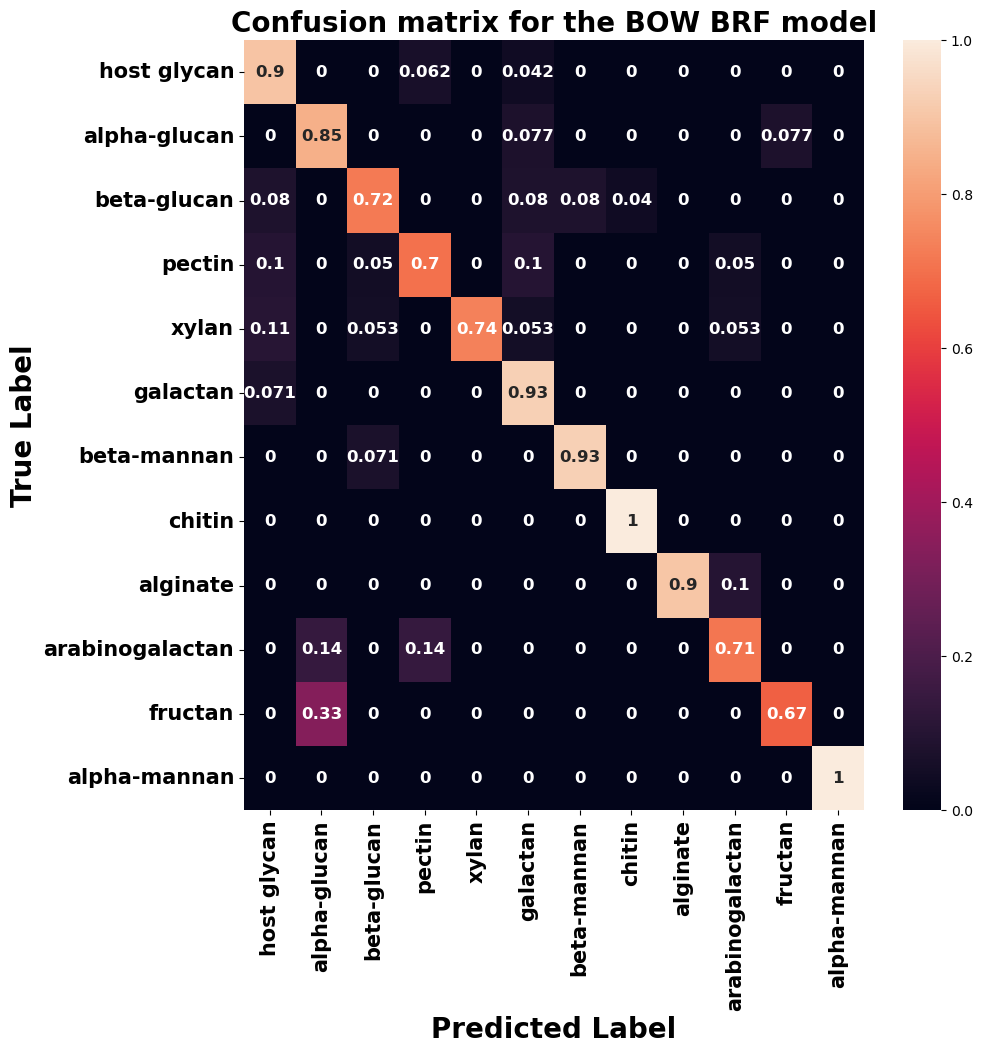

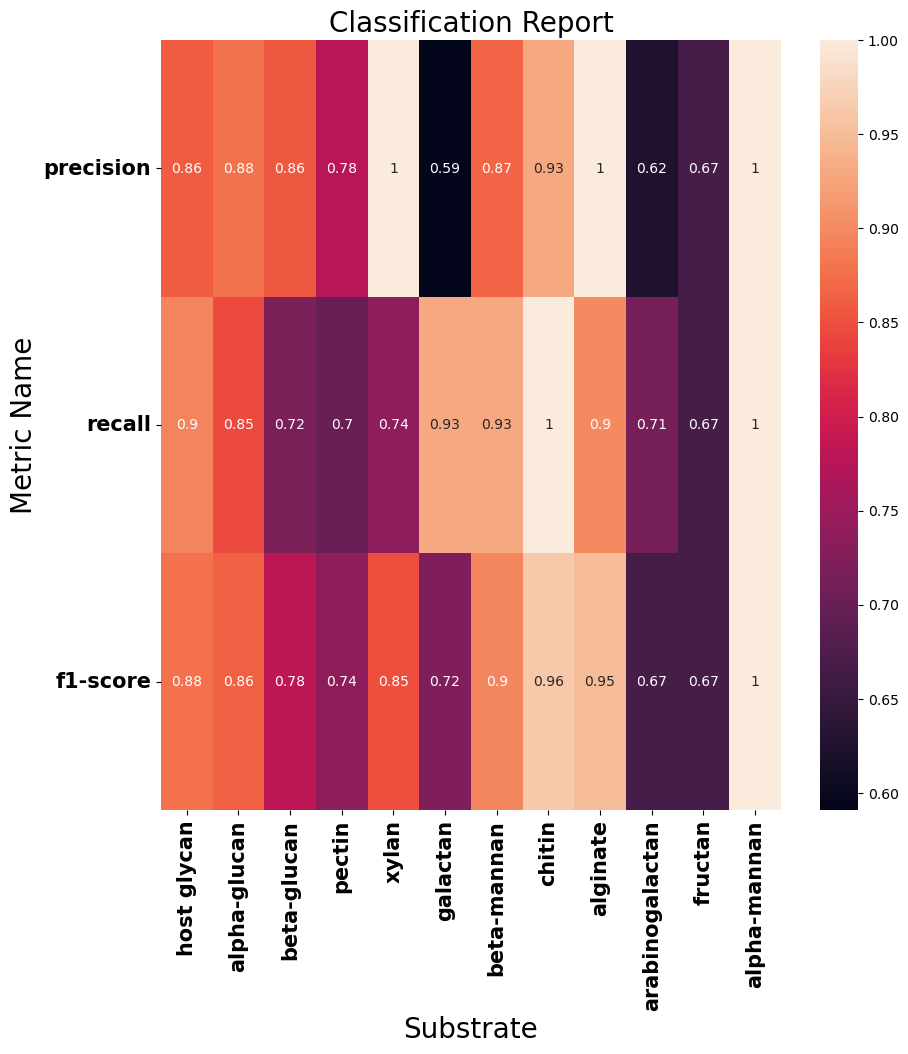

In [8]:
accuracy, class_accuracy, best_params, best_model, confusion_matrix_plot, report_plot, report, overall_metrics = run_end_to_end(
    data_path='Data/Train_data.csv',  # Your input data
    save_path='best_model.joblib',
    test_size=0.2  # Size of test set (20%)
)

In [9]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import  LabelEncoder
import joblib
from sklearn.metrics import balanced_accuracy_score

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report


In [14]:
def custom_tokenizer(x):
    return str(x).replace("|", ",").split(',')

def run_end_to_end(data_path, save_path='trained_model.h5', figures_dir='figures/', n_folds=5, random_state=42):
    # Create figures directory if it doesn't exist
    os.makedirs(figures_dir, exist_ok=True)
    
    data = pd.read_csv(data_path)
    # Define parameters
    parameters_one_vs_rest = {
        "vr__estimator__n_estimators": [100], 
        "vr__estimator__class_weight": ["balanced"],
        "vr__estimator__sampling_strategy": ["all"],  
        "vr__estimator__replacement": [True],         
        "vr__estimator__bootstrap": [False]           
    }    
    
    # Get order of classes
    order = list(data["high_level_substr"].value_counts().index)        
    
    # Prepare label encoder
    le = LabelEncoder()
    le.fit(data[["high_level_substr"]].values.reshape(-1,1).ravel())    
    joblib.dump(le, 'label_encoder.pkl')
    
    # Create StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Initialize lists to store results
    fold_accuracies = []
    fold_balanced_accuracies = []
    all_true_labels = []
    all_predicted_labels = []
    all_fold_indices = []
    best_estimators = []
    
    # Create pipeline
    clf_one_vs_rest = Pipeline([
        ('vectorizer', CountVectorizer(
            tokenizer=custom_tokenizer, 
            lowercase=False
        )), 
        ('vr', OneVsRestClassifier(BalancedRandomForestClassifier(n_jobs=-1)))
    ])
    
    # Perform cross-validation
    fold_idx = 0
    individual_fold_cms = []
    
    for train_index, test_index in skf.split(data["sig_gene_seq"].values, data["high_level_substr"].values):
        X_train, X_test = data["sig_gene_seq"].values[train_index], data["sig_gene_seq"].values[test_index]
        y_train, y_test = data["high_level_substr"].values[train_index], data["high_level_substr"].values[test_index]
        
        # Perform grid search on this fold
        gs_one_vs_rest = GridSearchCV(
            clf_one_vs_rest, 
            parameters_one_vs_rest, 
            cv=5, 
            n_jobs=7, 
            scoring="balanced_accuracy", 
            verbose=0
        )
        
        # Fit the model on this fold
        gs_one_vs_rest.fit(X_train, y_train)
        
        # Get best parameters and make predictions
        best_params = gs_one_vs_rest.best_params_
        y_test_pred = gs_one_vs_rest.predict(X_test)
        
        # Store results
        fold_accuracies.append(accuracy_score(y_test, y_test_pred))
        fold_balanced_accuracies.append(balanced_accuracy_score(y_test, y_test_pred))
        all_true_labels.extend(y_test)
        all_predicted_labels.extend(y_test_pred)
        all_fold_indices.extend([fold_idx] * len(y_test))
        best_estimators.append(gs_one_vs_rest.best_estimator_)
        
        # Create individual fold confusion matrix
        fold_cm = confusion_matrix(y_test, y_test_pred, labels=order, normalize='true')
        individual_fold_cms.append(fold_cm)
        
        # Save individual fold confusion matrix
        fig_fold_cm = plt.figure(figsize=(10, 8))
        df_fold_cm = pd.DataFrame(fold_cm, index=order, columns=order)
        sns.heatmap(df_fold_cm, annot=True, annot_kws={"fontsize":10, "weight":"bold"}, cmap="Blues")
        plt.title(f"Confusion Matrix - Fold {fold_idx+1}", fontsize=16, weight="bold")
        plt.xlabel("Predicted Label", weight="bold", fontsize=14)
        plt.ylabel("True Label", weight="bold", fontsize=14)
        plt.xticks(rotation=90, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/confusion_matrix_fold_{fold_idx+1}.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        fold_idx += 1
    
    # Convert to numpy arrays for easier handling
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)
    all_fold_indices = np.array(all_fold_indices)
    
    # Calculate overall metrics
    overall_cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=order, normalize='true')
    overall_acc = accuracy_score(all_true_labels, all_predicted_labels)
    avg_class_acc = np.mean(np.diag(overall_cm))
    
    # Create overall report
    report = pd.DataFrame(classification_report(all_true_labels, all_predicted_labels, labels=order, output_dict=True)).iloc[:3, :len(order)]
    overall_report = report.mean(1)
    
    # 1. Save Overall Confusion Matrix
    fig_overall_cm = plt.figure(figsize=(10, 8))
    df_cm = pd.DataFrame(overall_cm, index=order, columns=order)
    sns.heatmap(df_cm, annot=True, annot_kws={"fontsize":10, "weight":"bold"}, cmap="Blues")
    plt.title("Overall Confusion Matrix (All Folds)", fontsize=16, weight="bold")
    plt.xlabel("Predicted Label", weight="bold", fontsize=14)
    plt.ylabel("True Label", weight="bold", fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/overall_confusion_matrix.png", dpi=300, bbox_inches='tight')
    
    # 2. Save Classification Report
    fig_report = plt.figure(figsize=(10, 8))
    sns.heatmap(report, annot=True, cmap="YlGnBu")
    plt.title("Classification Report", fontsize=16, weight="bold")
    plt.ylabel("Metric", fontsize=14, weight="bold")
    plt.xlabel("Class", fontsize=14, weight="bold")
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/classification_report.png", dpi=300, bbox_inches='tight')
    
    # 3. Save Per-fold Performance
    fig_fold_perf = plt.figure(figsize=(12, 8))
    fold_data = pd.DataFrame({
        'Fold': range(1, n_folds + 1),
        'Accuracy': fold_accuracies,
        'Balanced Accuracy': fold_balanced_accuracies
    })
    fold_data_melted = fold_data.melt(id_vars=['Fold'], var_name='Metric', value_name='Score')
    sns.barplot(x='Fold', y='Score', hue='Metric', data=fold_data_melted)
    plt.title("Performance Across Folds", fontsize=16, weight="bold")
    plt.xlabel("Fold", fontsize=14, weight="bold")
    plt.ylabel("Score", fontsize=14, weight="bold")
    plt.axhline(overall_acc, color='blue', linestyle='--', label=f'Overall Acc: {overall_acc:.3f}')
    plt.axhline(avg_class_acc, color='orange', linestyle='--', label=f'Overall Bal Acc: {avg_class_acc:.3f}')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/fold_performance.png", dpi=300, bbox_inches='tight')
    
    # 4. Save Per-class Performance
    fig_class_perf = plt.figure(figsize=(14, 8))
    class_metrics = pd.DataFrame(classification_report(all_true_labels, all_predicted_labels, labels=order, output_dict=True))
    class_data = class_metrics.loc[['precision', 'recall', 'f1-score'], order].T
    class_data_melted = class_data.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
    sns.barplot(x='index', y='Score', hue='Metric', data=class_data_melted)
    plt.title("Per-class Performance", fontsize=16, weight="bold")
    plt.xlabel("Class", fontsize=14, weight="bold")
    plt.ylabel("Score", fontsize=14, weight="bold")
    plt.xticks(rotation=90, fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/class_performance.png", dpi=300, bbox_inches='tight')
    
    # 5. Combined Confusion Matrix for all folds
    num_classes = len(order)
    fig_all_cms = plt.figure(figsize=(num_classes * n_folds, num_classes))
    
    for i in range(n_folds):
        ax = plt.subplot(1, n_folds, i+1)
        fold_cm_df = pd.DataFrame(individual_fold_cms[i], index=order, columns=order)
        sns.heatmap(fold_cm_df, annot=True, annot_kws={"fontsize":8}, ax=ax, cmap="Blues", 
                    cbar=False if i < n_folds-1 else True)
        ax.set_title(f"Fold {i+1}", fontsize=14, weight="bold")
        if i == 0:
            ax.set_ylabel("True Label", fontsize=12, weight="bold")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Predicted Label", fontsize=12, weight="bold")
        ax.set_xticklabels(order, rotation=90, fontsize=10)
        ax.set_yticklabels(order, rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/all_fold_confusion_matrices.png", dpi=300, bbox_inches='tight')
    
    # 6. Create combined visualization figure (all in one)
    fig_combined, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Subplot 1: Overall Confusion Matrix
    sns.heatmap(df_cm, annot=True, annot_kws={"fontsize":10, "weight":"bold"}, ax=axes[0, 0], cmap="Blues")
    axes[0, 0].set_title("Confusion Matrix (All Folds)", fontsize=16, weight="bold")
    axes[0, 0].set_xlabel("Predicted Label", weight="bold", fontsize=14)
    axes[0, 0].set_ylabel("True Label", weight="bold", fontsize=14)
    axes[0, 0].tick_params(axis='both', labelsize=12, labelrotation=90)
    
    # Subplot 2: Classification Report
    sns.heatmap(report, annot=True, ax=axes[0, 1], cmap="YlGnBu")
    axes[0, 1].set_title("Classification Report", fontsize=16, weight="bold")
    axes[0, 1].set_ylabel("Metric", fontsize=14, weight="bold")
    axes[0, 1].set_xlabel("Class", fontsize=14, weight="bold")
    axes[0, 1].tick_params(axis='both', labelsize=12, labelrotation=90)
    
    # Subplot 3: Per-fold Performance
    sns.barplot(x='Fold', y='Score', hue='Metric', data=fold_data_melted, ax=axes[1, 0])
    axes[1, 0].set_title("Performance Across Folds", fontsize=16, weight="bold")
    axes[1, 0].set_xlabel("Fold", fontsize=14, weight="bold")
    axes[1, 0].set_ylabel("Score", fontsize=14, weight="bold")
    axes[1, 0].axhline(overall_acc, color='blue', linestyle='--', label=f'Overall Acc: {overall_acc:.3f}')
    axes[1, 0].axhline(avg_class_acc, color='orange', linestyle='--', label=f'Overall Bal Acc: {avg_class_acc:.3f}')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Subplot 4: Per-class Performance
    sns.barplot(x='index', y='Score', hue='Metric', data=class_data_melted, ax=axes[1, 1])
    axes[1, 1].set_title("Per-class Performance", fontsize=16, weight="bold")
    axes[1, 1].set_xlabel("Class", fontsize=14, weight="bold")
    axes[1, 1].set_ylabel("Score", fontsize=14, weight="bold")
    axes[1, 1].tick_params(axis='x', rotation=90)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/combined_visualization.png", dpi=300, bbox_inches='tight')
    
    # Find best model across all folds
    best_estimator_idx = np.argmax(fold_balanced_accuracies)
    best_estimator = best_estimators[best_estimator_idx]
    
    # Save the best model
    joblib.dump(best_estimator, save_path)
    
    # Return results
    results = {
        'overall_acc': overall_acc,
        'avg_class_acc': avg_class_acc,
        'fold_accuracies': fold_accuracies,
        'fold_balanced_accuracies': fold_balanced_accuracies,
        'best_estimator': best_estimator,
        'best_fold': best_estimator_idx + 1,
        'figures': {
            'overall_cm': fig_overall_cm,
            'report': fig_report,
            'fold_performance': fig_fold_perf,
            'class_performance': fig_class_perf,
            'all_fold_cms': fig_all_cms,
            'combined': fig_combined
        },
        'report': report,
        'overall_report': overall_report
    }
    
    return results

/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/yifan/miniconda3/envs/subfinder/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token

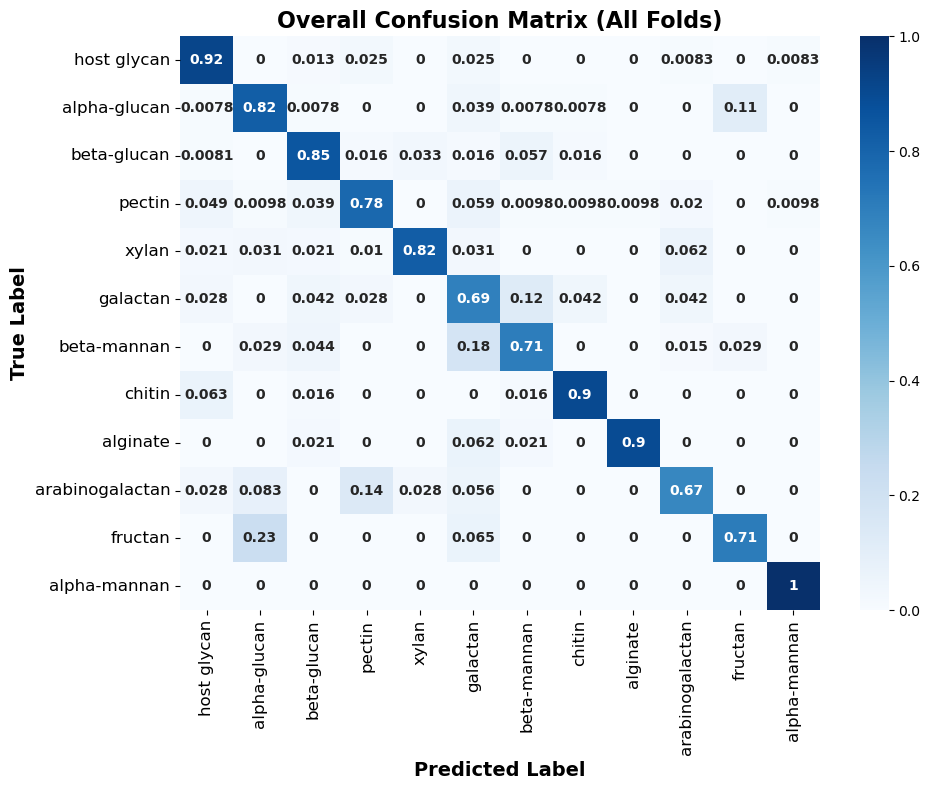

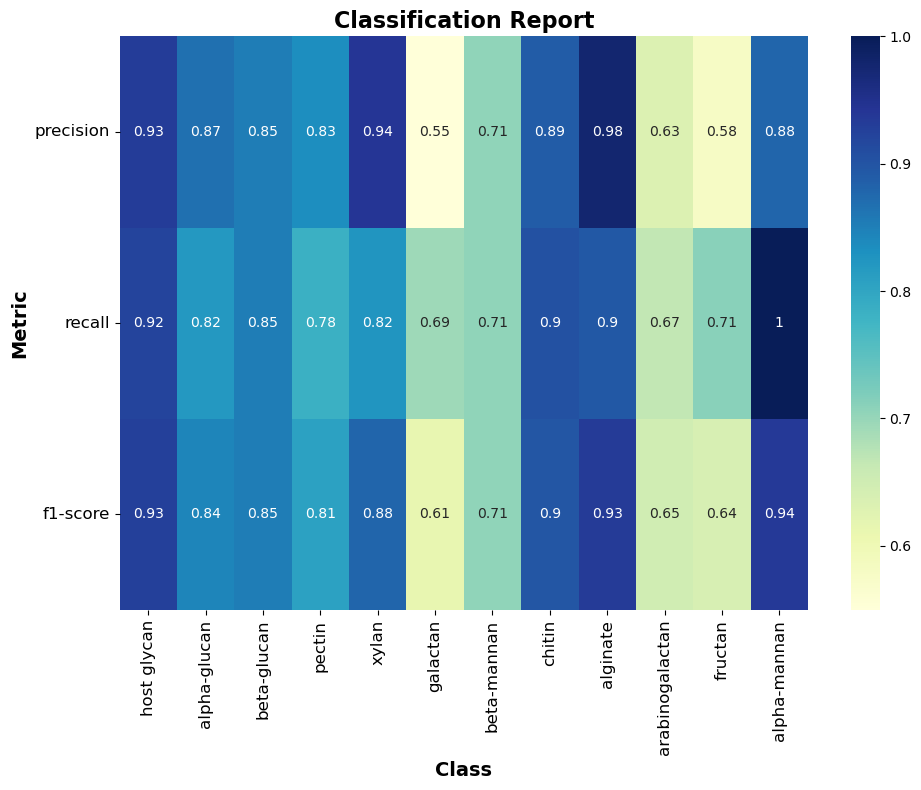

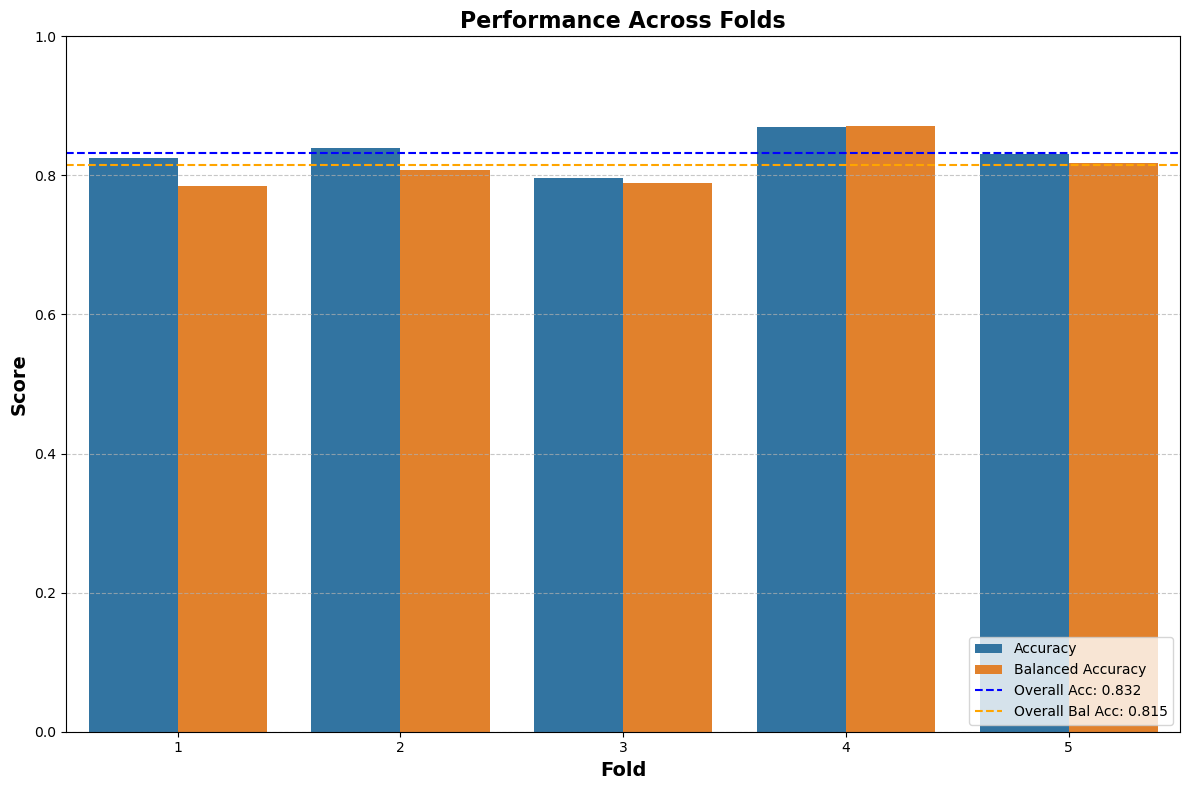

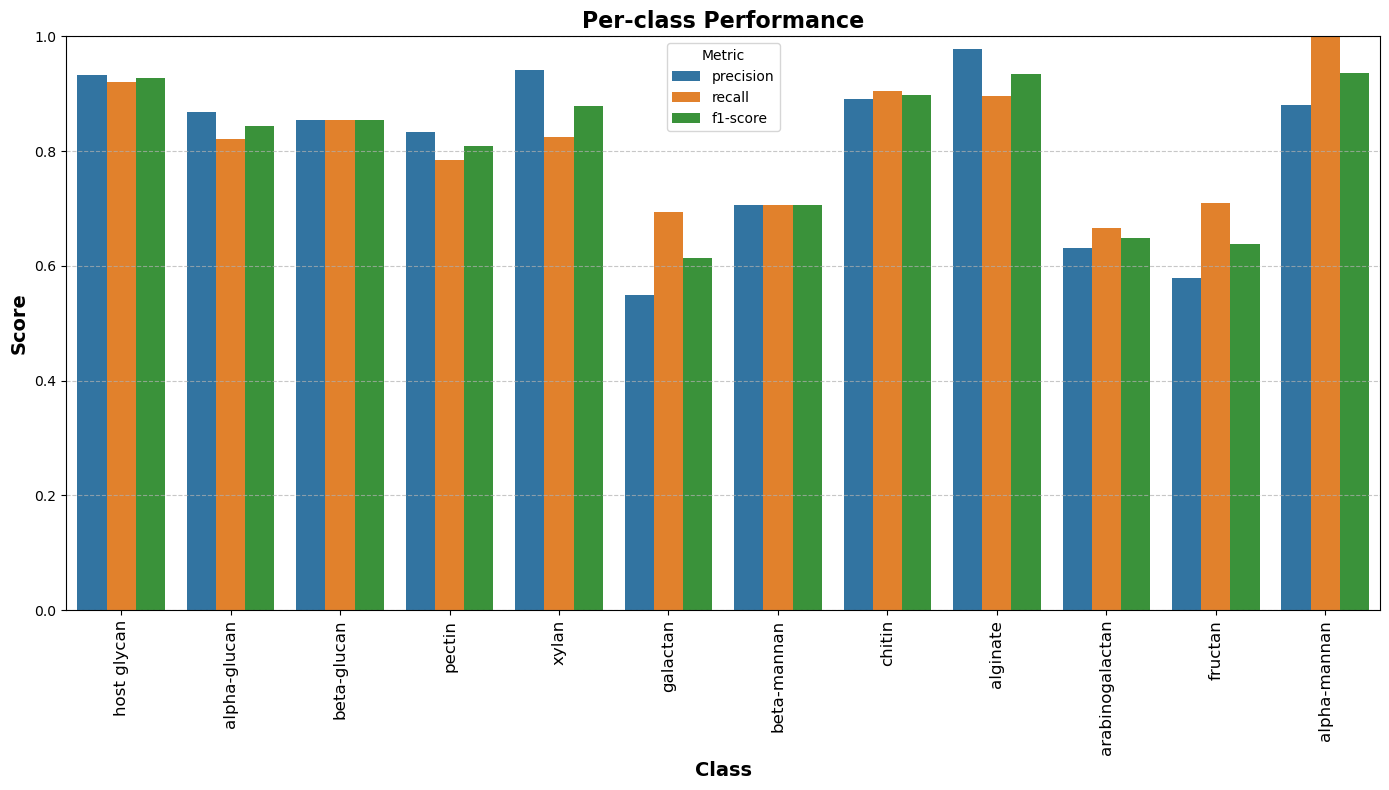

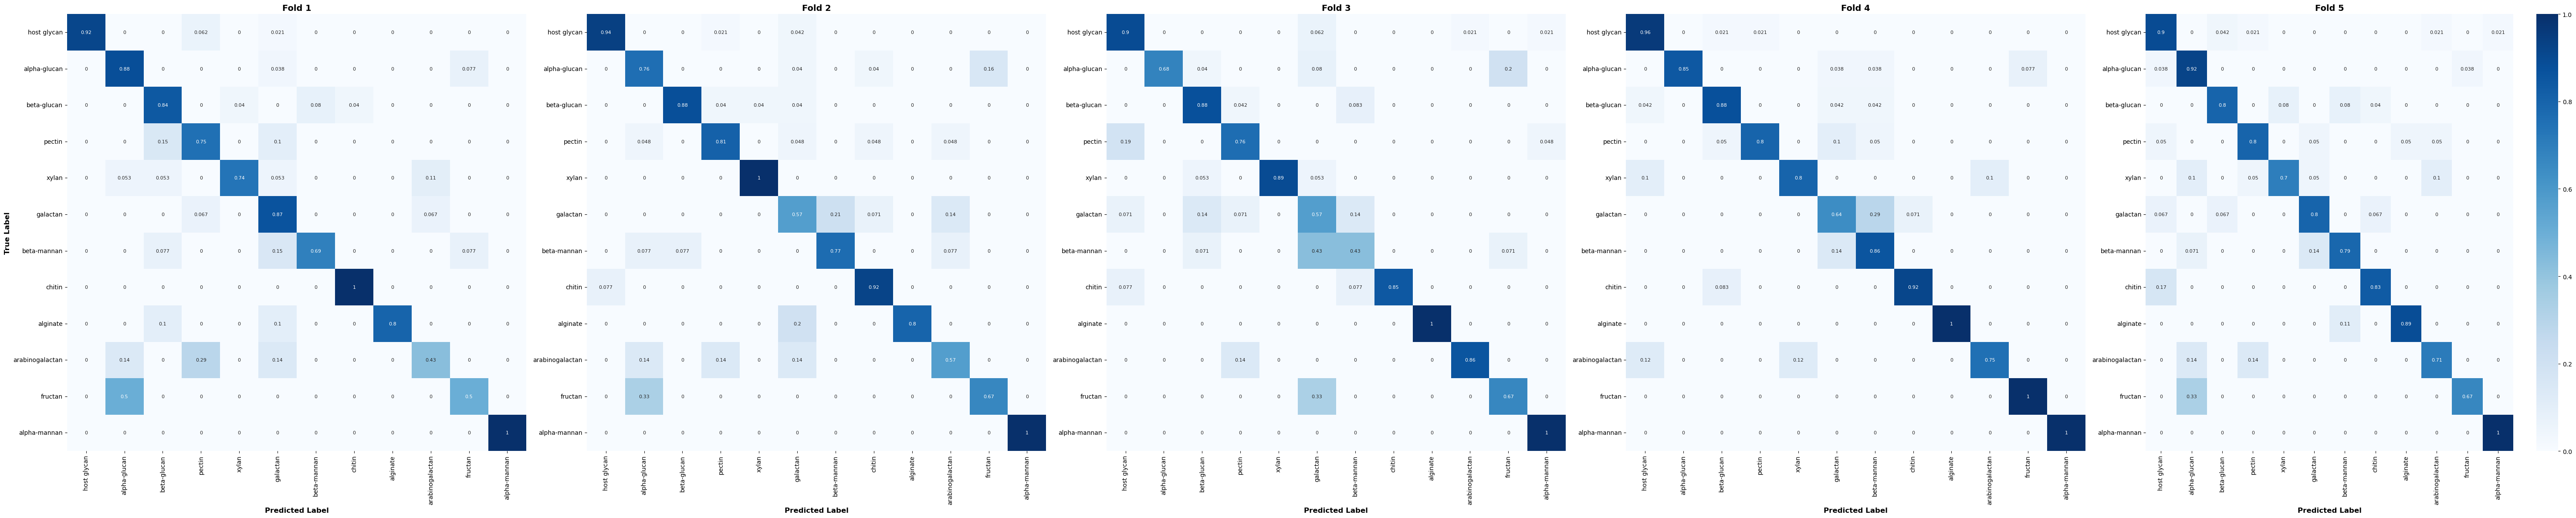

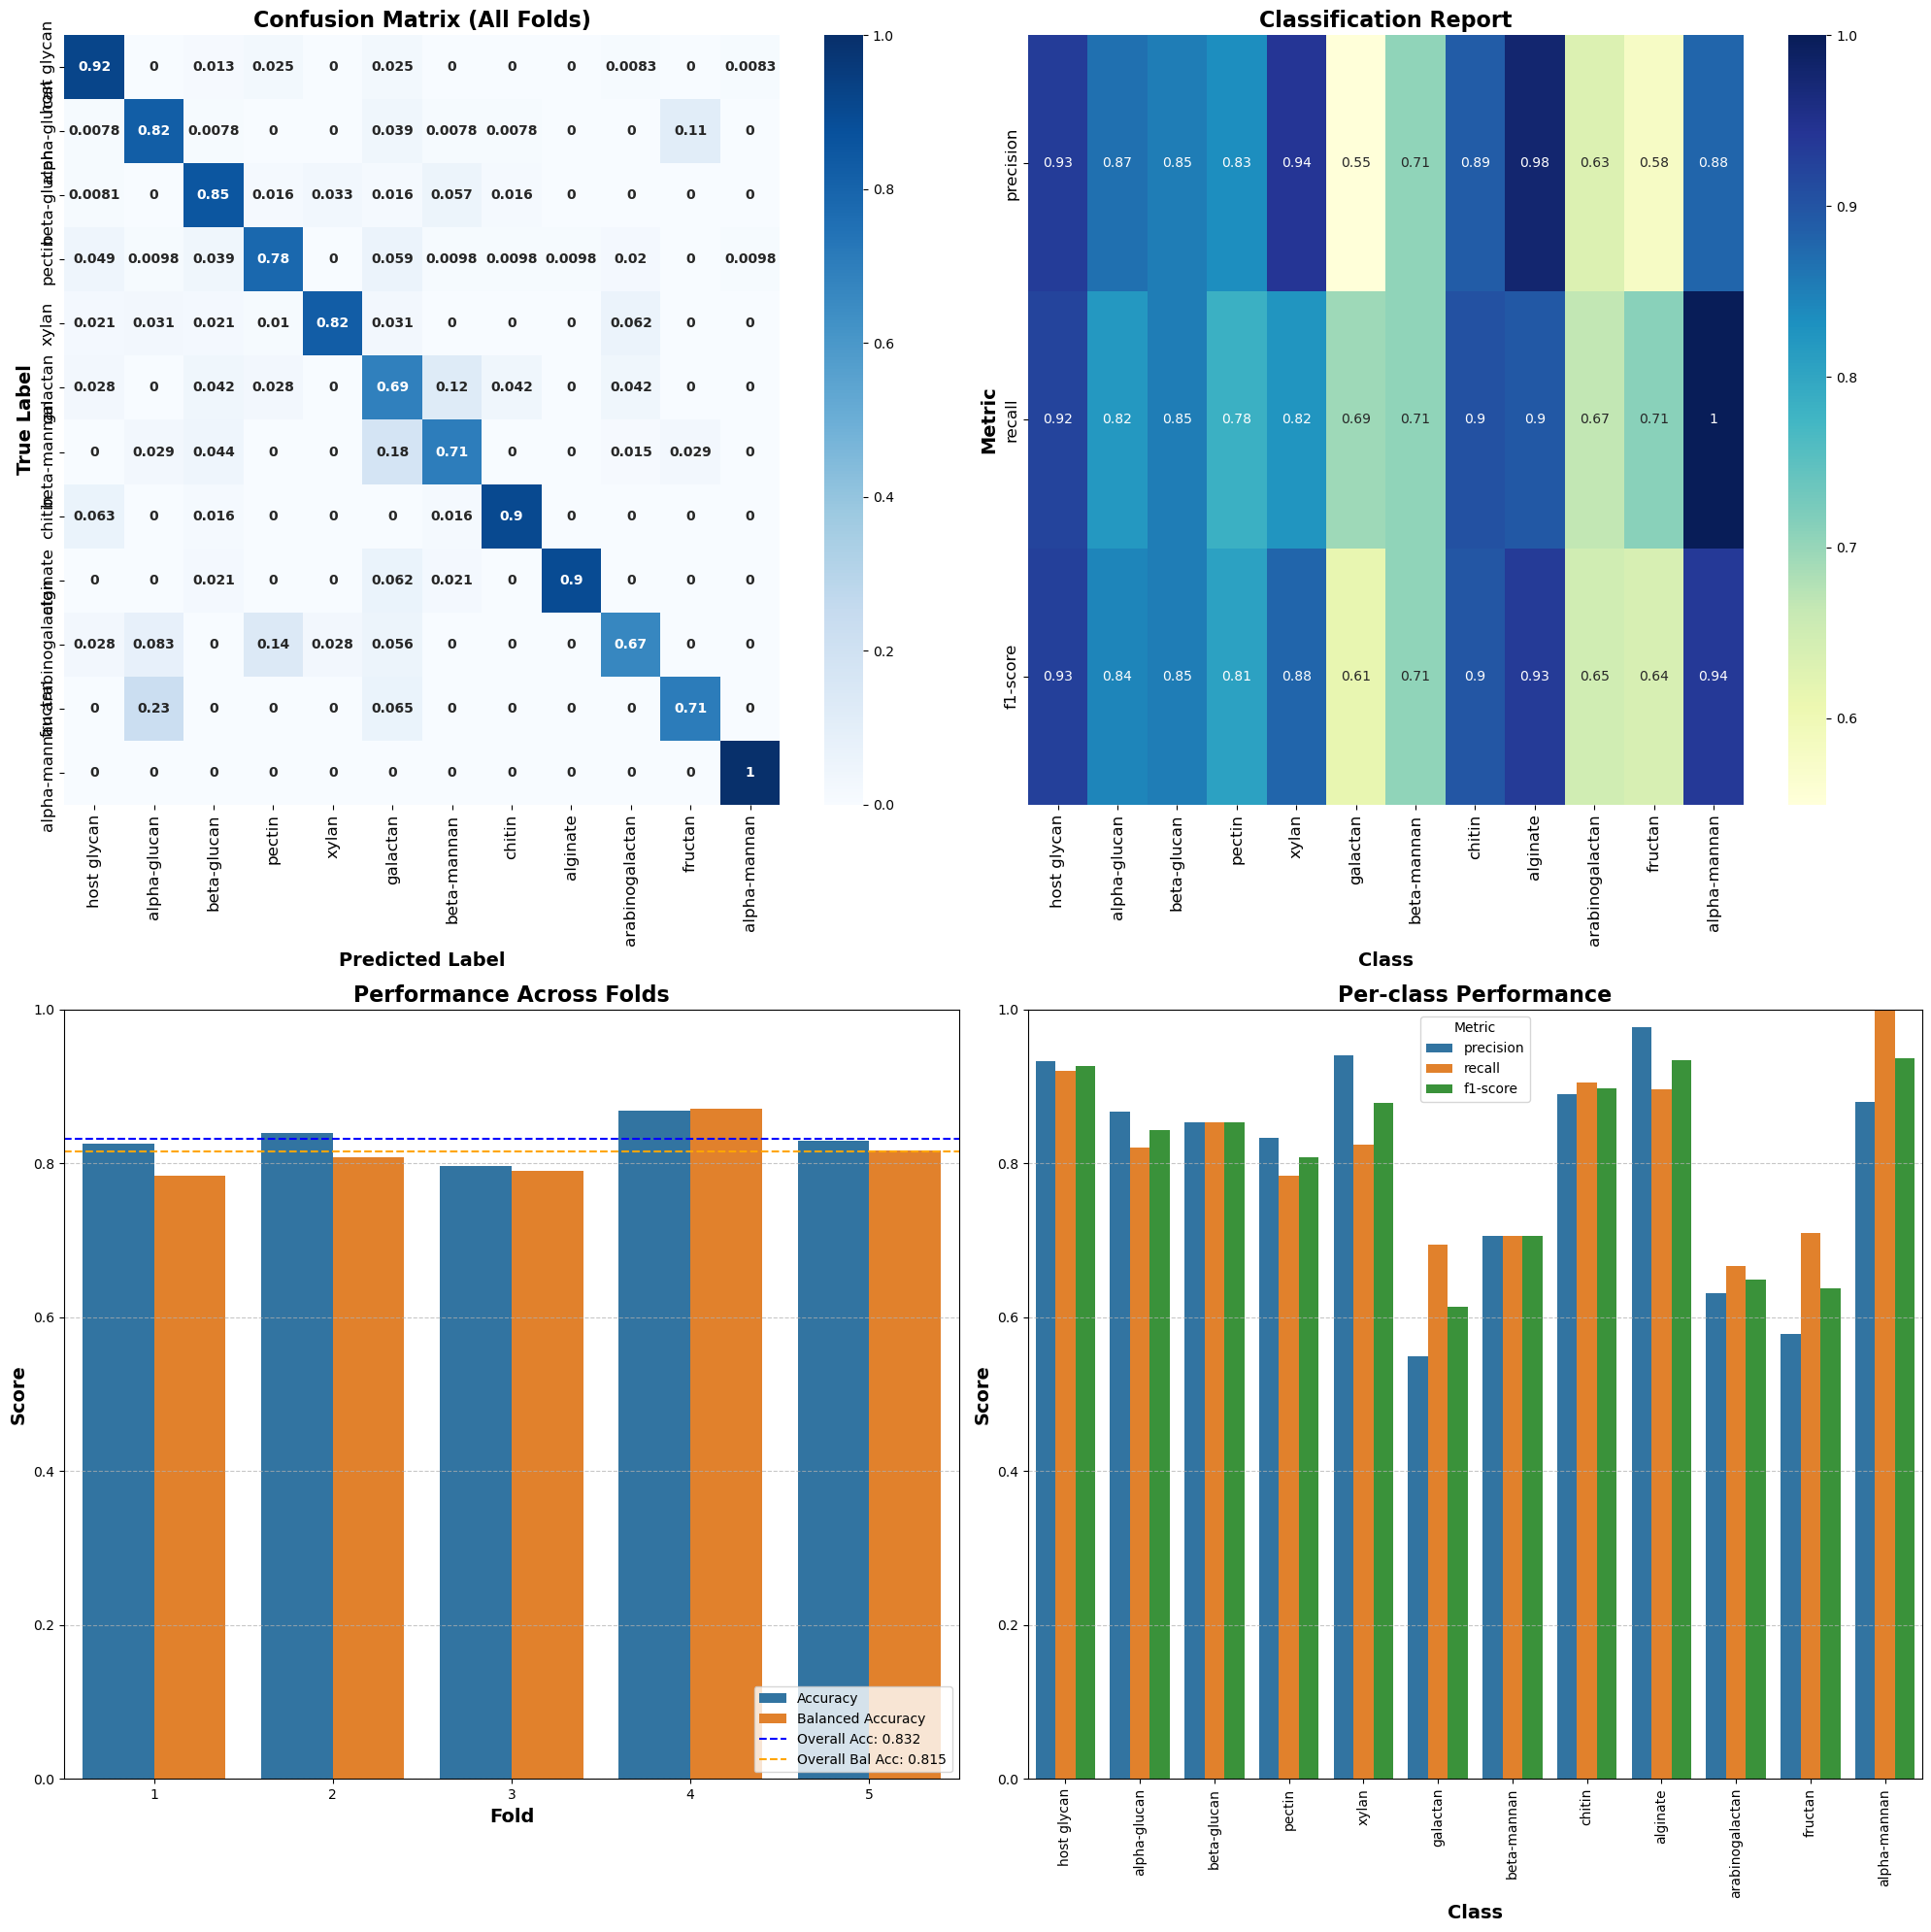

In [15]:
result = run_end_to_end(
    data_path='../Data/Train_data.csv',  # Your input data
    save_path='best_model.joblib',
)